In [89]:
# extension autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import yaml
from scipy.interpolate import splprep, splev
from scipy.spatial.transform import Rotation as R

%matplotlib widget   

In [91]:
map_path = Path("../tigerstack/maps/skir.pgm")
output_path = map_path.with_suffix(".csv")

config = yaml.load(map_path.with_suffix(".yaml").read_text(), yaml.CLoader)
origin = config["origin"]
resolution = config["resolution"]

track_img = plt.imread(str(map_path))

width = track_img.shape[1] * resolution
height = track_img.shape[0] * resolution
extent = [origin[0], origin[0] + width, origin[1], origin[1] + height]


In [92]:
inner_bounds = np.array(
    [
        [-2.55, 1.87],
        [3.31, 1.73],
        [3.33, 8.6],
        [2.9, 8.62],
        [2.75, 2.65],
        [-2.55, 2.65],
    ]
)
outer_bounds = np.array(
    [
        [-5.99, -0.63],
        [5.86, -0.82],
        [6.12, 13.53],
        [0.61, 13.58],
        [0.2, 6.26],
        [-5.87, 6.45],
    ]
)

center = np.array(
    [
        [-2.62, 1.08],
        [0.22, 0.31],
        [3.33, 0.45],
        [4.82, 2.12],
        [4.92, 5.56],
        [4.8, 8.0],
        [3.14, 9.4],
        [1.52, 8.0],
        [1.52, 6.43],
        [-0.14, 4.16],
        [-2.28, 3.59],
        [-3.21, 2.24],
    ]
)

angle = 0.0
rot_mat = R.from_euler("Z", angle).as_matrix()[:2, :2]

# add the first point to the end to close the polygon
inner_bounds = np.vstack((inner_bounds, inner_bounds[0])) @ rot_mat.T
outer_bounds = np.vstack((outer_bounds, outer_bounds[0])) @ rot_mat.T
center = np.vstack((center, center[0])) @ rot_mat.T


In [93]:
def intersect_ray_segment(rayOrigin, rayDirection, point1, point2):
    v1 = rayOrigin - point1
    v2 = point2 - point1
    v3 = np.array([-rayDirection[1], rayDirection[0]])
    t1 = np.cross(v2, v1) / np.dot(v2, v3)
    t2 = np.dot(v1, v3) / np.dot(v2, v3)
    if t1 >= 0.0 and t2 >= 0.0 and t2 <= 1.0:
        return rayOrigin + t1 * rayDirection
    return None


def intersect_ray_polygon(rayOrigin, rayDirection, polygon):
    closestIntersection = None
    for i in range(len(polygon) - 1):
        p1 = polygon[i]
        p2 = polygon[i + 1]
        intersection = intersect_ray_segment(rayOrigin, rayDirection, p1, p2)
        if intersection is not None:
            if closestIntersection is None or np.linalg.norm(
                rayOrigin - intersection
            ) < np.linalg.norm(rayOrigin - closestIntersection):
                closestIntersection = intersection
    return closestIntersection


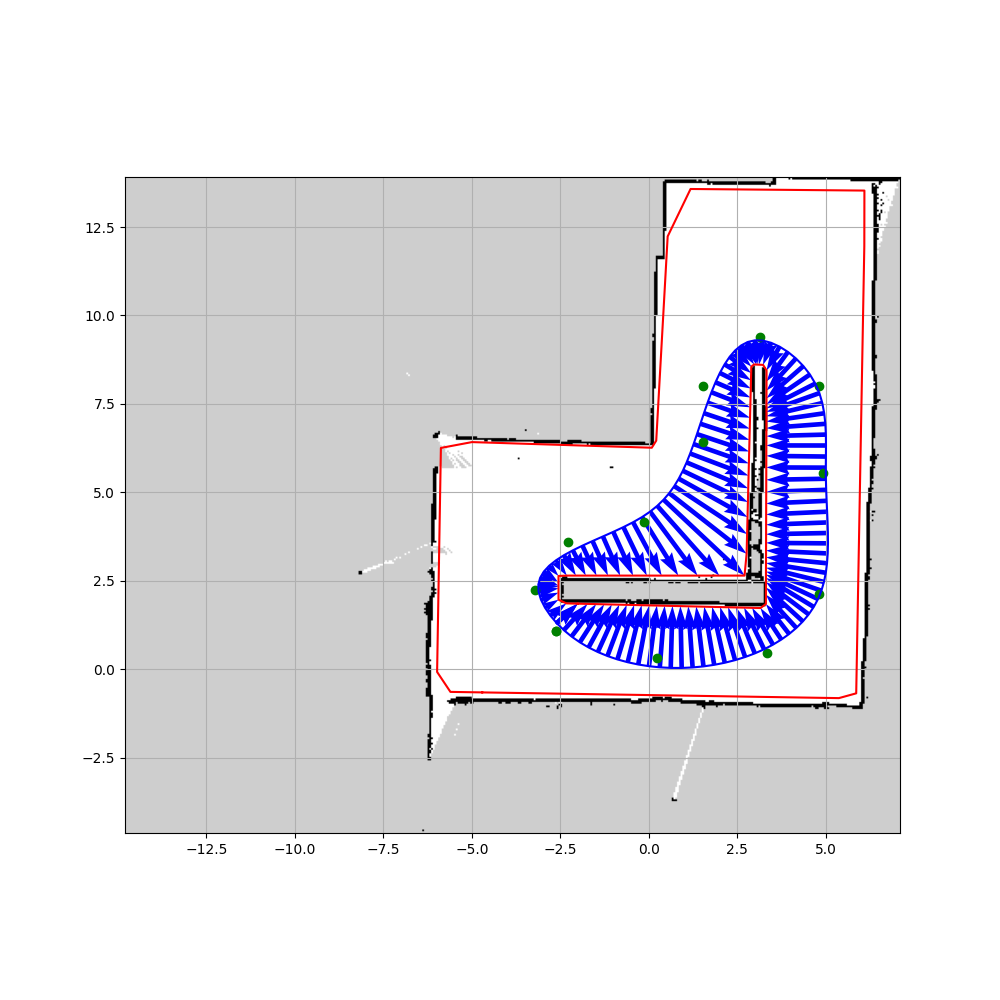

In [94]:
from scipy.interpolate import splprep, splev

# fit spline to centerline
u = np.linspace(0, 1, 100)
tck, _ = splprep(center.T, k=3, s=0.5, per=1)
center_interp = np.stack(splev(u, tck), axis=-1)

# get the normal vector to the centerline
tangent = np.stack(splev(u, tck, der=1), axis=-1)
normal = np.stack([-tangent[:, 1], tangent[:, 0]], axis=-1)
normal /= np.linalg.norm(normal, axis=1, keepdims=True)

# get the width of the track
inner = np.zeros_like(center_interp)
outer = np.zeros_like(center_interp)
for i, (c, n) in enumerate(zip(center_interp, normal)):
    inner[i] = intersect_ray_polygon(c, n, inner_bounds)
    outer[i] = intersect_ray_polygon(c, -n, outer_bounds)

width_right = np.linalg.norm(outer - center_interp, axis=1)
width_left = np.linalg.norm(inner - center_interp, axis=1)

plt.figure(figsize=(10, 10))
plt.imshow(track_img, cmap="gray", extent=extent)
plt.plot(*center.T, "go")
plt.plot(*center_interp.T, "b-")
plt.plot(*inner.T, "r-")
plt.plot(*outer.T, "r-")

# quiver plot of the normal vector
plt.quiver(
    *center_interp.T,
    *normal.T * width_left,
    scale=1,
    scale_units="xy",
    angles="xy",
    color="b",
)

# plt.xlim(-7.4, 7)
plt.grid(True)
plt.show()


In [95]:
# save the track data
import csv

output_path = Path(
    "../../../../external/global_racetrajectory_optimization/inputs/tracks/skir.csv"
)
with open(output_path, "w") as f:
    f.write("# x, y, width_right, width_left\n")
    writer = csv.writer(f)
    for i in range(len(center_interp)):
        writer.writerow(
            [
                *center_interp[i],
                width_right[i],
                width_left[i],
            ]
        )


# Drawing points on map

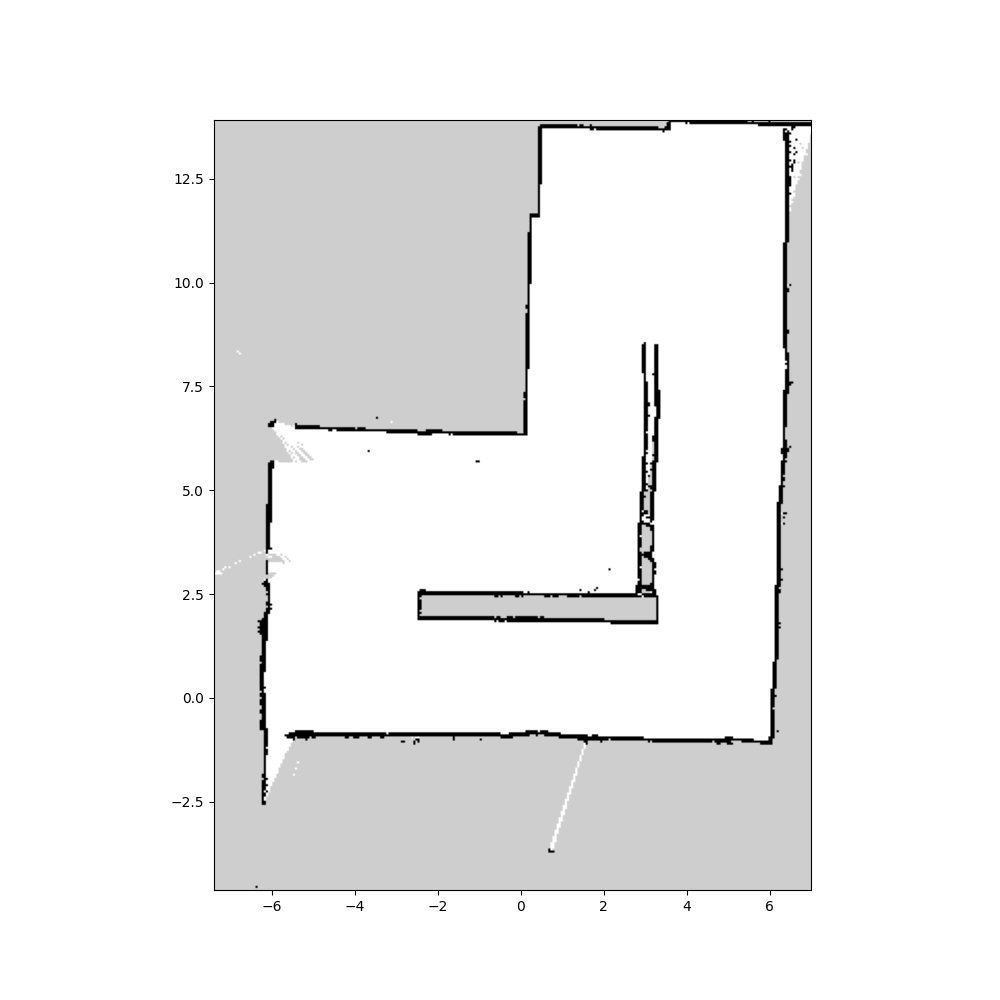

In [96]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(track_img, cmap="gray", extent=extent)
plt.xlim(-7.4, 7)

points = []


def onclick(event):
    # if event is a left click
    if event.button == 1:
        # add the point to the list
        points.append([event.xdata, event.ydata])
        # plot the point
        plt.plot(event.xdata, event.ydata, "ro")
        # redraw the plot
        fig.canvas.draw()


# connect the click event to the onclick function
fig.canvas.mpl_connect("button_press_event", onclick)
plt.show()


In [97]:
np.round(points, 2)


array([], dtype=float64)